<a href="https://colab.research.google.com/github/afzaldo7/Data-Science-Assessment-/blob/main/Data_Science_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
train = pd.read_csv('/content/train.csv', parse_dates=['date'])
test=pd.read_csv('/content/test.csv')
stores = pd.read_csv('/content/stores.csv')
oil = pd.read_csv('/content/oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv('/content/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('/content/transactions.csv', parse_dates=['date'])

In [3]:
# Handle missing values in oil prices using interpolation
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [4]:
# Merge datasets
train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holidays_events, on='date', how='left')

In [5]:
# Convert date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [6]:
# Feature Engineering
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

In [7]:
# Holiday & Event Features
train['is_holiday'] = train['type_y'].notna().astype(int)
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)
train['is_gov_payday'] = train.apply(
    lambda row: int(row['day'] in [15, row['date'].days_in_month]), axis=1
)

train['earthquake_impact'] = (train['date'] == '2016-04-16').astype(int)

In [8]:
# Rolling Statistics & Lag Features
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).mean().reset_index(level=[0,1], drop=True)
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).std().reset_index(level=[0,1], drop=True)

In [9]:
# Store-Specific Aggregations
store_avg_sales = train.groupby('store_nbr')['sales'].mean().rename('avg_store_sales')
train = train.merge(store_avg_sales, on='store_nbr', how='left')

Exploratory Data Analysis


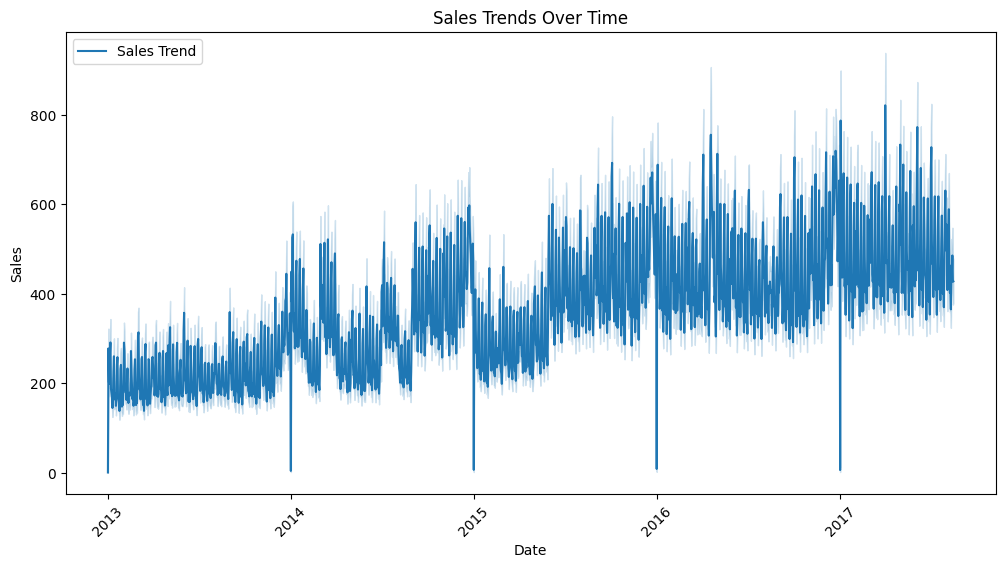

In [10]:
# Exploratory Data Analysis (EDA)
print("Exploratory Data Analysis")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', data=train, label='Sales Trend')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

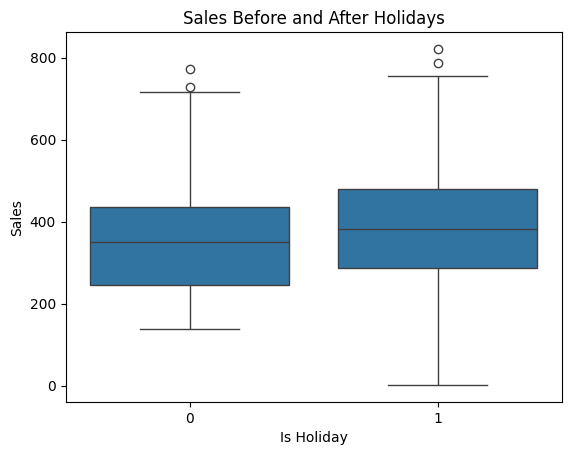

In [11]:
# Analyze Pre/Post-Holiday and Promotion Sales
holiday_sales = train.groupby(['date', 'is_holiday'])['sales'].mean().reset_index()
sns.boxplot(x='is_holiday', y='sales', data=holiday_sales)
plt.title('Sales Before and After Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()

Correlation between Sales and Oil Prices:
               sales  dcoilwtico
sales       1.000000   -0.079009
dcoilwtico -0.079009    1.000000


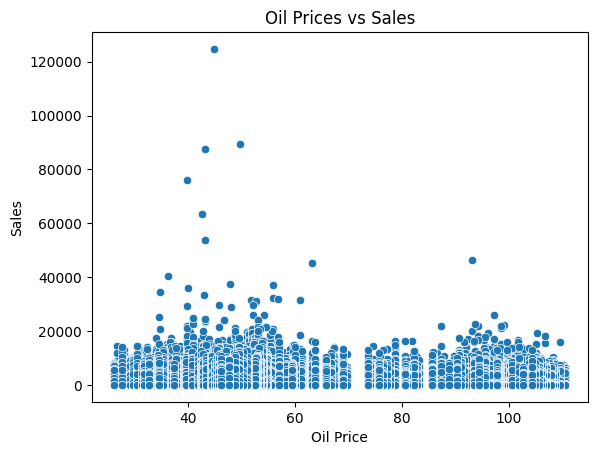

In [12]:
# Check Correlations Between Oil Prices & Sales
correlation = train[['sales', 'dcoilwtico']].corr()
print("Correlation between Sales and Oil Prices:")
print(correlation)
sns.scatterplot(x='dcoilwtico', y='sales', data=train)
plt.title('Oil Prices vs Sales')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.show()

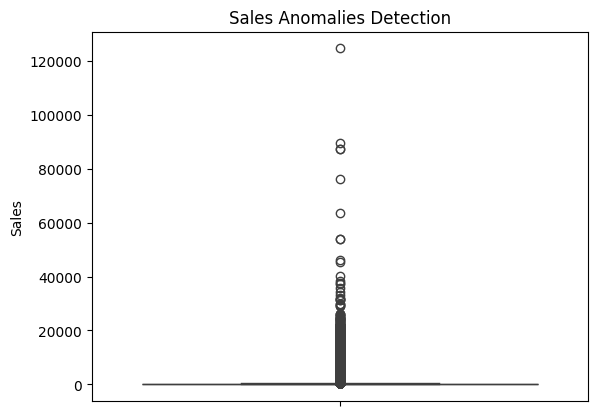

In [13]:
# Detect Anomalies in Sales Trends
sns.boxplot(y='sales', data=train)
plt.title('Sales Anomalies Detection')
plt.ylabel('Sales')
plt.show()

In [14]:
# Save processed dataset
train.to_csv('processed_train.csv', index=False)

print("Data processing and feature engineering completed.")

Data processing and feature engineering completed.


In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [16]:
# Load processed dataset
train = pd.read_csv('processed_train.csv', parse_dates=['date'], low_memory=False)

In [17]:
# Baseline Model - Naïve Forecasting
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)

In [28]:
# Prepare training data
features = ['day', 'week', 'month', 'year', 'day_of_week', 'is_holiday', 'is_weekend',
            'is_gov_payday', 'earthquake_impact', 'sales_lag_7', 'sales_lag_30',
            'rolling_mean_7', 'rolling_std_7', 'avg_store_sales']
X = train[features].dropna()
y = train.loc[X.index, 'sales']

In [19]:
# Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [20]:
y_train_sample = y_train.iloc[-10000:]  # Use only the last 10,000 records

In [21]:
# Train ARIMA Model
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps=len(y_val))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

In [22]:
rf_model = RandomForestRegressor(
    n_estimators=50,  # Reduce trees
    max_depth=10,  # Limit depth
    n_jobs=-1,  # Enable parallelism
    bootstrap=False,  # Reduce overhead
    random_state=42
)

X_sample, y_sample = X_train.sample(50000, random_state=42), y_train.loc[X_train.sample(50000, random_state=42).index]
rf_model.fit(X_sample, y_sample)
rf_preds = rf_model.predict(X_val)

In [23]:
rf_model.fit(X_sample, y_sample)

RandomForestRegressor(bootstrap=False, max_depth=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [24]:
rf_model.predict(X_sample)

array([191.5412496 ,   3.24605501, 313.21990291, ..., 489.70811932,
        39.93198059,  15.44235662])

In [25]:
# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

In [26]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")


print("Model Evaluation:")
if 'arima_preds' in locals():
    evaluate_model(y_val, arima_preds, "ARIMA")
else:
    print("ARIMA predictions not found.")
if "rf_model" in locals():
    rf_preds = rf_model.predict(X_val)
else:
    print("Random Forest model not trained.")

evaluate_model(y_val, arima_preds, "ARIMA")
evaluate_model(y_val, rf_preds, "Random Forest")
evaluate_model(y_val, xgb_preds, "XGBoost")

Model Evaluation:
ARIMA - RMSE: 1411.32, MAPE: 10195183152728457216.00%, R2: -0.06
ARIMA - RMSE: 1411.32, MAPE: 10195183152728457216.00%, R2: -0.06
Random Forest - RMSE: 431.90, MAPE: 975344682013655424.00%, R2: 0.90
XGBoost - RMSE: 307.43, MAPE: 728251545701144448.00%, R2: 0.95


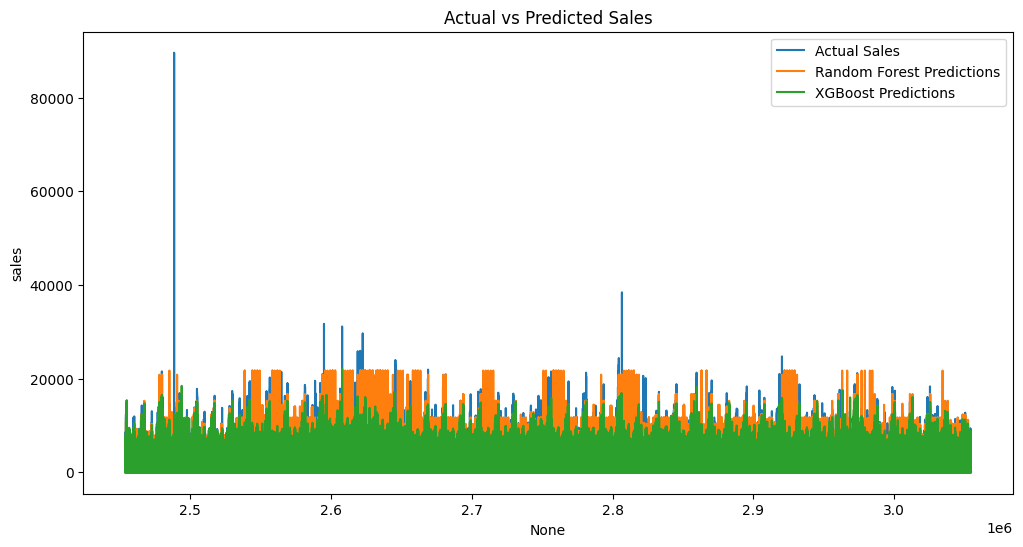

Model training, forecasting, and evaluation completed.


In [27]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_val.index, y=y_val, label='Actual Sales')
sns.lineplot(x=y_val.index, y=rf_preds, label='Random Forest Predictions')
sns.lineplot(x=y_val.index, y=xgb_preds, label='XGBoost Predictions')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

print("Model training, forecasting, and evaluation completed.")